In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import os; os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
from jax.config import config
config.update("jax_debug_nans", True)

In [4]:
import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

2023-09-20 16:24:51.647068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from typing import Any, Callable, Sequence, Union
import numpy as np
from fastcore.xtras import Path
from fastprogress.fastprogress import master_bar, progress_bar
import pandas as pd
import cv2

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.initializers import mean
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

2023-09-20 16:25:35.855067: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_DEVICE_UNAVAILABLE: CUDA-capable device(s) is/are busy or unavailable
2023-09-20 16:25:35.855357: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:1: failed initializing StreamExecutor for CUDA device ordinal 1: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_DEVICE_UNAVAILABLE: CUDA-capable device(s) is/are busy or unavailable
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Wandb config

In [6]:
config = {
        'epochs':500,
        'learning_rate':3e-4,
        'batch_size':64,
        'kernel_initializer':'ones',
        'gdn_kernel_size':1,
        'learnable_undersampling':False,
        'verbose': 0,
        'dataset': 'cifar10', # imagenet / imagenette / cifar10 / cifar100,
        'validation_split': 0.2,
        'seed': 42,
        'GAP': False,
        'use_bias': False,
    }

In [7]:
wandb.init(project='PerceptNetClassification_JaX',
            notes="",
            tags=[],
            name = 'Baseline-Flatten-NoBias',
            config=config,
            job_type="training",
            mode="disabled",
            )
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


# Load the data

In [8]:
def load_imagenet():
    path_data = Path("/lustre/ific.uv.es/ml/uv075/Databases/imagenet_images/")
    dst_train = tf.keras.utils.image_dataset_from_directory(
                path_data,
                validation_split=config.validation_split,
                subset="training",
                seed=config.seed,
                shuffle=True,
                # image_size=(img_height, img_width),
                batch_size=config.batch_size)
    dst_val = tf.keras.utils.image_dataset_from_directory(
                path_data,
                validation_split=config.validation_split,
                subset="validation",
                seed=config.seed,
                shuffle=False,
                # image_size=(img_height, img_width),
                batch_size=config.batch_size)
    return dst_train, dst_val

In [9]:
def load_imagenette():
    import tensorflow_datasets as tfds

    dst_train, info = tfds.load("imagenette/320px-v2", split=f"train[:{(1-config.validation_split)*100:.0f}%]", with_info=True, shuffle_files=True)
    dst_val = tfds.load("imagenette/320px-v2", split=f"train[{(1-config.validation_split)*100:.0f}%:]", with_info=False, shuffle_files=False)
    def prepare_tfds(item):
        x, y = item["image"], item["label"]
        x = tf.image.resize_with_crop_or_pad(x, 256, 256)
        return x, y
    dst_train = dst_train.map(prepare_tfds)
    dst_val = dst_val.map(prepare_tfds)

    return dst_train.batch(config.batch_size), dst_val.batch(config.batch_size), info.features["label"].num_classes

In [10]:
def load_cifar10():
    from tensorflow.keras.datasets import cifar10
    from sklearn.model_selection import train_test_split

    (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=config.validation_split, random_state=config.seed)
    dst_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dst_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

    return dst_train.batch(config.batch_size), dst_val.batch(config.batch_size)

In [11]:
def load_cifar100():
    from tensorflow.keras.datasets import cifar100
    from sklearn.model_selection import train_test_split

    (X_train, Y_train), (X_test, Y_test) = cifar100.load_data()
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=config.validation_split, random_state=config.seed)
    dst_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dst_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

    return dst_train.batch(config.batch_size), dst_val.batch(config.batch_size)

In [12]:
if config.dataset == "imagenet":
    dst_train, dst_val = load_imagenet()
    N_CLASSES = len(dst_train.class_names)
elif config.dataset == "cifar10":
    dst_train, dst_val = load_cifar10()
    N_CLASSES = 10
elif config.dataset == "cifar100":
    dst_train, dst_val = load_cifar100()
    N_CLASSES = 100
elif config.dataset == "imagenette":
    dst_train, dst_val, N_CLASSES = load_imagenette()
else:
    raise ValueError("Dataset parameter not allowed.")
print(f"Training on {config.dataset} with {N_CLASSES} classes.")

Training on cifar10 with 10 classes.


In [13]:
x, y = next(iter(dst_train))
input_shape = x[0].shape
input_shape

TensorShape([32, 32, 3])

In [14]:
wandb.run.summary["N_CLASSES"] = N_CLASSES
wandb.run.summary["Input_Shape"] = tuple(input_shape)

In [15]:
dst_tid2013 = TID2013("/lustre/ific.uv.es/ml/uv075/Databases/IQA/TID/TID2013").dataset\
                                                                              .batch(config.batch_size)\
                                                                              .prefetch(1)

### Normalize the data

In [16]:
dst_train = dst_train.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y[:,0]))
dst_val = dst_val.map(lambda x,y: (tf.cast(x, tf.float32)/255.0, y[:,0]))

### Performance

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

dst_train_rdy = dst_train.cache().prefetch(buffer_size=1)
dst_val_rdy = dst_val.cache().prefetch(buffer_size=1)

# Define the model

In [18]:
class GDN(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    apply_independently: bool = False
    # kernel_init: Callable = nn.initializers.lecun_normal()
    kernel_init: Callable = mean()
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 ):
        denom = nn.Conv(features=inputs.shape[-1], # Same output channels as input
                        kernel_size=self.kernel_size if isinstance(self.kernel_size, Sequence) else [self.kernel_size]*2, 
                        strides=self.strides, 
                        padding=self.padding,
                        feature_group_count=inputs.shape[-1] if self.apply_independently else 1,
                        kernel_init=self.kernel_init, 
                        bias_init=self.bias_init)(jnp.clip(inputs**self.alpha, a_min=1e-5))
        return inputs / (denom**self.epsilon + self.eps)

In [19]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=True)(inputs)
        outputs = nn.Conv(features=3, kernel_size=(1,1), strides=1, padding="SAME", use_bias=config.use_bias)(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False)(outputs)
        outputs = nn.Conv(features=6, kernel_size=(5,5), strides=1, padding="SAME", use_bias=config.use_bias)(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False)(outputs)
        outputs = nn.Conv(features=128, kernel_size=(5,5), strides=1, padding="SAME", use_bias=config.use_bias)(outputs)
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False)(outputs)
        return outputs

In [20]:
class Classifier(nn.Module):

    @nn.compact
    def __call__(self,
                 inputs,
                 ):
        outputs = nn.Dense()

In [21]:
class PerceptNetClassifier(nn.Module):
    """Classifier with a PerceptNet backbone."""

    def setup(self):
        self.perceptnet = PerceptNet()
        self.cls = nn.Dense(N_CLASSES)

    def __call__(self,
                 inputs,
                 ):
        outputs = self.perceptnet(inputs)
        # outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = reduce(outputs, "b h w c -> b c", reduction="mean") if config.GAP else rearrange(outputs, "b h w c -> b (h w c)")
        outputs = self.cls(outputs)
        return outputs

In [22]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output("loss")

In [23]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

In [24]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

In [25]:
variables = PerceptNetClassifier().init(random.PRNGKey(config.seed), jnp.zeros((1,32,32,3)))

In [26]:
state = create_train_state(PerceptNetClassifier(), random.PRNGKey(config.seed), optax.adam(config.learning_rate), input_shape=(1,32,32,3))
state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

Log the number of trainable weights:

In [27]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
param_count

118161

In [28]:
wandb.run.summary["trainable_parameters"] = param_count

In [29]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

## Train the model!

In [30]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    img, label = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred = state.apply_fn({"params": params, **state.state}, img)

        ## Calculate crossentropy
        return optax.softmax_cross_entropy_with_integer_labels(img_pred, label).mean(), img_pred
    
    (loss, dist_diff), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss, logits=dist_diff, labels=jnp.round(label).astype(int))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

In [31]:
@jax.jit
def val_step(state, batch):
    """Train for a single step."""
    img, label = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred = state.apply_fn({"params": params, **state.state}, img)

        ## Calculate crossentropy
        return optax.softmax_cross_entropy_with_integer_labels(img_pred, label).mean(), img_pred
    
    loss, dist_diff = loss_fn(state.params)
    metrics_updates = state.metrics.single_from_model_output(loss=loss, logits=dist_diff, labels=jnp.round(label).astype(int))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

In [32]:
def forward_pass(state, img):
    img_pred = PerceptNet().apply({"params": state.params["perceptnet"]}, img)
    return img_pred

In [33]:
def rmse(a, b): return jnp.sqrt(jnp.sum((a-b)**2, axis=(1,2,3)))

In [34]:
@jax.jit
def obtain_distances(state, batch):
    ref, dist, mos = batch
    pred_ref = forward_pass(state, ref)
    pred_dist = forward_pass(state, dist)
    distance = rmse(pred_ref, pred_dist)
    return distance

In [35]:
import scipy.stats as stats

In [36]:
def obtain_correlation(state, dst):
    distances, moses = [], []
    for batch in dst:
        distance = obtain_distances(state, batch)
        distances.extend(distance)
        moses.extend(batch[2])
        # break
    return stats.pearsonr(distances, moses)[0]

In [38]:
metrics_history = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
    "correlation": [0.],
}

In [39]:
%%time
for epoch in range(config.epochs):
    ## Training
    for batch in dst_train_rdy.as_numpy_iterator():
        state = train_step(state, batch)
        state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))
        # state = compute_metrics(state=state, batch=batch)
        # break

    ## Log the metrics
    for name, value in state.metrics.compute().items():
        metrics_history[f"train_{name}"].append(value)
    
    ## Empty the metrics
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation (Classification)
    for batch in dst_val_rdy.as_numpy_iterator():
        state = val_step(state=state, batch=batch)
        break
    for name, value in state.metrics.compute().items():
        metrics_history[f"val_{name}"].append(value)
    state = state.replace(metrics=state.metrics.empty())

    ## Evaluation (Correlation)
    # correlation = obtain_correlation(state, dst_tid2013.as_numpy_iterator())
    # metrics_history["correlation"].append(correlation)
    
    ## Checkpointing
    if metrics_history["val_loss"][-1] <= min(metrics_history["val_loss"]):
        orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-best"), state, save_args=save_args, force=True) # force=True means allow overwritting.

    wandb.log({f"{k}": wandb.Histogram(v) for k, v in flatten_params(state.params).items()}, commit=False)
    wandb.log({"epoch": epoch+1, **{name:values[-1] for name, values in metrics_history.items()}})
    print(f'Epoch {epoch} -> [Train] Loss: {metrics_history["train_loss"][-1]:.3f} Acc: {metrics_history["train_accuracy"][-1]:.3f} [Val] Loss: {metrics_history["val_loss"][-1]:.3f} Acc: {metrics_history["val_accuracy"][-1]:.3f} || Corr: {metrics_history["correlation"][-1]:.3f}')
    # break

2023-09-20 16:28:01.571891: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 0 -> [Train] Loss: 1.802 Acc: 0.365 [Val] Loss: 1.602 Acc: 0.453 || Corr: 0.000


2023-09-20 16:28:43.419999: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1 -> [Train] Loss: 1.624 Acc: 0.435 [Val] Loss: 1.548 Acc: 0.500 || Corr: 0.000


2023-09-20 16:29:23.882536: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2 -> [Train] Loss: 1.562 Acc: 0.456 [Val] Loss: 1.491 Acc: 0.500 || Corr: 0.000


2023-09-20 16:30:04.285005: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3 -> [Train] Loss: 1.514 Acc: 0.472 [Val] Loss: 1.454 Acc: 0.516 || Corr: 0.000


2023-09-20 16:30:44.647473: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 4 -> [Train] Loss: 1.478 Acc: 0.483 [Val] Loss: 1.430 Acc: 0.516 || Corr: 0.000


2023-09-20 16:31:24.969276: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 5 -> [Train] Loss: 1.450 Acc: 0.494 [Val] Loss: 1.406 Acc: 0.469 || Corr: 0.000


2023-09-20 16:32:05.269432: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 6 -> [Train] Loss: 1.427 Acc: 0.503 [Val] Loss: 1.384 Acc: 0.469 || Corr: 0.000


2023-09-20 16:32:45.294712: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 7 -> [Train] Loss: 1.406 Acc: 0.509 [Val] Loss: 1.364 Acc: 0.484 || Corr: 0.000


2023-09-20 16:33:25.498203: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 8 -> [Train] Loss: 1.388 Acc: 0.514 [Val] Loss: 1.349 Acc: 0.484 || Corr: 0.000


2023-09-20 16:34:05.900824: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 9 -> [Train] Loss: 1.372 Acc: 0.519 [Val] Loss: 1.338 Acc: 0.469 || Corr: 0.000


2023-09-20 16:34:46.069815: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 10 -> [Train] Loss: 1.358 Acc: 0.522 [Val] Loss: 1.330 Acc: 0.469 || Corr: 0.000


2023-09-20 16:35:26.811106: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 11 -> [Train] Loss: 1.345 Acc: 0.526 [Val] Loss: 1.323 Acc: 0.453 || Corr: 0.000


2023-09-20 16:36:07.648857: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 12 -> [Train] Loss: 1.334 Acc: 0.530 [Val] Loss: 1.317 Acc: 0.438 || Corr: 0.000


2023-09-20 16:36:48.115251: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 13 -> [Train] Loss: 1.324 Acc: 0.533 [Val] Loss: 1.312 Acc: 0.438 || Corr: 0.000


2023-09-20 16:37:28.937273: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 14 -> [Train] Loss: 1.315 Acc: 0.537 [Val] Loss: 1.306 Acc: 0.438 || Corr: 0.000


2023-09-20 16:38:09.229078: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 15 -> [Train] Loss: 1.305 Acc: 0.540 [Val] Loss: 1.300 Acc: 0.422 || Corr: 0.000


2023-09-20 16:38:49.615461: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 16 -> [Train] Loss: 1.296 Acc: 0.543 [Val] Loss: 1.294 Acc: 0.438 || Corr: 0.000


2023-09-20 16:39:30.376971: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 17 -> [Train] Loss: 1.287 Acc: 0.545 [Val] Loss: 1.287 Acc: 0.438 || Corr: 0.000


2023-09-20 16:40:11.281005: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 18 -> [Train] Loss: 1.278 Acc: 0.548 [Val] Loss: 1.281 Acc: 0.422 || Corr: 0.000


2023-09-20 16:40:51.551460: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 19 -> [Train] Loss: 1.269 Acc: 0.551 [Val] Loss: 1.273 Acc: 0.438 || Corr: 0.000


2023-09-20 16:41:32.356721: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 20 -> [Train] Loss: 1.259 Acc: 0.555 [Val] Loss: 1.265 Acc: 0.453 || Corr: 0.000


2023-09-20 16:42:13.480548: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 21 -> [Train] Loss: 1.250 Acc: 0.559 [Val] Loss: 1.257 Acc: 0.453 || Corr: 0.000


2023-09-20 16:42:54.418021: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 22 -> [Train] Loss: 1.240 Acc: 0.562 [Val] Loss: 1.249 Acc: 0.453 || Corr: 0.000


2023-09-20 16:43:35.224132: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 23 -> [Train] Loss: 1.230 Acc: 0.565 [Val] Loss: 1.241 Acc: 0.453 || Corr: 0.000


2023-09-20 16:44:16.404354: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 24 -> [Train] Loss: 1.221 Acc: 0.569 [Val] Loss: 1.235 Acc: 0.469 || Corr: 0.000


2023-09-20 16:44:57.500481: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 25 -> [Train] Loss: 1.210 Acc: 0.572 [Val] Loss: 1.229 Acc: 0.469 || Corr: 0.000


2023-09-20 16:45:38.544783: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 26 -> [Train] Loss: 1.200 Acc: 0.576 [Val] Loss: 1.224 Acc: 0.469 || Corr: 0.000


2023-09-20 16:46:19.774641: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 27 -> [Train] Loss: 1.190 Acc: 0.580 [Val] Loss: 1.219 Acc: 0.469 || Corr: 0.000


2023-09-20 16:47:00.878755: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 28 -> [Train] Loss: 1.179 Acc: 0.584 [Val] Loss: 1.215 Acc: 0.484 || Corr: 0.000


2023-09-20 16:47:41.788610: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 29 -> [Train] Loss: 1.168 Acc: 0.587 [Val] Loss: 1.212 Acc: 0.484 || Corr: 0.000


2023-09-20 16:48:22.614665: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 30 -> [Train] Loss: 1.157 Acc: 0.591 [Val] Loss: 1.209 Acc: 0.484 || Corr: 0.000
Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in jit(mul)

In [167]:
distances, moses = [], []
for b in dst_tid2013.as_numpy_iterator():
    distance = obtain_distances(state, b)
    distances.extend(distance)
    moses.extend(batch[2])
    # break

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [182]:
s = train_step(state, batch)

Invalid nan value encountered in the output of a C++-jit/pmap function. Calling the de-optimized version.


FloatingPointError: invalid value (nan) encountered in jit(mul)

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [49]:
import matplotlib.pyplot as plt

In [70]:
class GDN(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    apply_independently: bool = False
    # kernel_init: Callable = nn.initializers.lecun_normal()
    kernel_init: Callable = mean()
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 ):
        denom = nn.Conv(features=inputs.shape[-1], # Same output channels as input
                        kernel_size=self.kernel_size if isinstance(self.kernel_size, Sequence) else [self.kernel_size]*2, 
                        strides=self.strides, 
                        padding=self.padding,
                        feature_group_count=inputs.shape[-1] if self.apply_independently else 1,
                        kernel_init=self.kernel_init, 
                        bias_init=self.bias_init)(jnp.clip(inputs**self.alpha, a_min=1e-5))
        return inputs / (denom**self.epsilon + self.eps)

In [71]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs,
                 **kwargs,
                 ):
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=True, alpha=2.0, epsilon=0.5)(inputs)
        outputs = nn.Conv(features=3, kernel_size=(1,1), strides=1, padding="SAME", use_bias=config.use_bias)(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False, alpha=2.0, epsilon=0.5)(outputs)
        outputs = nn.Conv(features=6, kernel_size=(5,5), strides=1, padding="SAME", use_bias=config.use_bias)(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False, alpha=2.0, epsilon=0.5)(outputs)
        outputs = nn.Conv(features=128, kernel_size=(5,5), strides=1, padding="SAME", use_bias=config.use_bias)(outputs)
        outputs = GDN(kernel_size=1, strides=1, padding="SAME", apply_independently=False, alpha=2.0, epsilon=0.5)(outputs)
        return outputs

In [72]:
class PerceptNetClassifier(nn.Module):
    """Classifier with a PerceptNet backbone."""

    def setup(self):
        self.perceptnet = PerceptNet()
        self.cls = nn.Dense(N_CLASSES)

    def __call__(self,
                 inputs,
                 ):
        outputs = self.perceptnet(inputs)
        # outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        outputs = reduce(outputs, "h w c -> c", reduction="mean") if config.GAP else rearrange(outputs, "h w c -> (h w c)")
        outputs = self.cls(outputs)
        return outputs

In [43]:
def loss_one_sample(params, img, label): 
    pred = PerceptNetClassifier().apply({"params": params}, img)
    # loss = optax.softmax_cross_entropy_with_integer_labels(logits=pred, labels=label)
    label = jnp.zeros_like(pred).at[label].set(1)
    loss = optax.l2_loss(pred, label).mean()
    return loss

In [73]:
loss_one_sample(state.params, batch[0][0], batch[1][0])

Array(0.89600277, dtype=float32)

In [74]:
for i in range(len(batch[0])):
    jax.value_and_grad(loss_one_sample, argnums=0)(state.params, batch[0][i], batch[1][i])

In [47]:
print(i)
img_prob, label_prob = batch[0][i], batch[1][i]

33


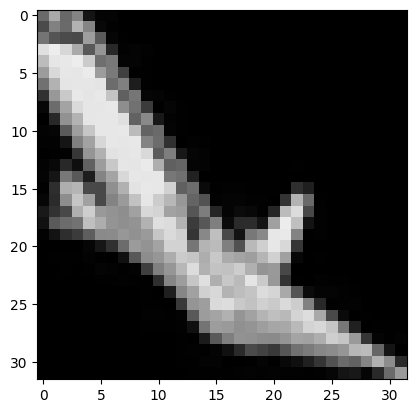

In [50]:
plt.imshow(batch[0][i])
plt.show()

In [75]:
img_pred, k = PerceptNetClassifier().apply({"params": state.params}, img_prob, capture_intermediates=True)
img_pred.shape

(10,)

In [76]:
r = k["intermediates"]["perceptnet"]["GDN_3"]["Conv_0"]["__call__"][0]**(3/2)
r.min()

Array(6.519498e-07, dtype=float32)

In [77]:
jax.value_and_grad(loss_one_sample, argnums=0)(state.params, img_prob, label_prob)

(Array(1.0922486, dtype=float32),
 FrozenDict({
     cls: {
         bias: Array([-0.03998941, -0.05710946,  0.12049019,  0.17887305, -0.12339189,
                 0.094022  , -0.25449842,  0.00121391, -0.2548282 , -0.11533251],      dtype=float32),
         kernel: Array([[ 2.0190156e-03,  2.8833856e-03, -6.0834000e-03, ...,
                 -6.1288869e-05,  1.2865960e-02,  5.8229947e-03],
                [-2.8738151e-03, -4.1041374e-03,  8.6589558e-03, ...,
                  8.7237007e-05, -1.8313078e-02, -8.2883015e-03],
                [ 1.6879268e-02,  2.4105528e-02, -5.0858118e-02, ...,
                 -5.1238394e-04,  1.0756131e-01,  4.8681092e-02],
                ...,
                [-5.7402956e-03, -8.1978003e-03,  1.7295811e-02, ...,
                  1.7425136e-04, -3.6579415e-02, -1.6555449e-02],
                [-2.3156214e-03, -3.3069728e-03,  6.9770887e-03, ...,
                  7.0292575e-05, -1.4756048e-02, -6.6784285e-03],
                [-1.0017490e-02, -1.43061

In [ ]:
orbax_checkpointer.save(os.path.join(wandb.run.dir, "model-final"), state, save_args=save_args)

In [ ]:
wandb.finish()